In [7]:
!pip install opencv-python

In [8]:
# importing cv2, time, uuid and os 
import cv2
import time
import os
import uuid

In [9]:
# importing all cv2 packages
from cv2 import *

In [7]:
#Capturing the images with the help of cv2 and generating different uuid
for images in range(30):
    
    cap = cv2.VideoCapture(0)
    result, image = cap.read()
    
    if result:
        cv2.imshow("image_show", image)
        cv2.imwrite(f'{str(uuid.uuid1())}.jpg', image)
        time.sleep(0.5)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()            
cv2.destroyAllWindows()

# Annotation of the images

In [10]:
#checking the list of all modules
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
alabaster                     0.7.12
albumentations                1.3.0
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
bi

In [10]:
# Useing labelme to label the images captured
!labelme

External WM_DESTROY received for  QWidgetWindow(0x13a529f45d0, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x13a5244a780, name="MainWindowClassWindow")


# Review Dataset and Building Image loading function

In [11]:
# import tf and other dependencies
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.config.list_physical_devices('GPU')

[]

# Load Image into TF Data pipeline

In [14]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [15]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [26]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [27]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [17]:
images.as_numpy_iterator().next()

array([[[ 82,  74,  38],
        [ 82,  74,  38],
        [ 82,  73,  42],
        ...,
        [188, 197, 202],
        [187, 198, 202],
        [186, 197, 201]],

       [[ 81,  73,  37],
        [ 81,  72,  39],
        [ 81,  72,  41],
        ...,
        [187, 196, 201],
        [186, 197, 201],
        [185, 196, 200]],

       [[ 81,  72,  39],
        [ 80,  71,  38],
        [ 80,  71,  40],
        ...,
        [186, 196, 198],
        [186, 196, 198],
        [186, 196, 198]],

       ...,

       [[ 88,  85,  52],
        [ 86,  86,  52],
        [ 87,  84,  53],
        ...,
        [127, 122, 103],
        [125, 122, 103],
        [126, 123, 104]],

       [[ 85,  85,  51],
        [ 84,  85,  51],
        [ 85,  84,  53],
        ...,
        [127, 122, 103],
        [125, 122, 103],
        [125, 122, 103]],

       [[ 84,  85,  51],
        [ 84,  85,  51],
        [ 84,  85,  53],
        ...,
        [126, 121, 102],
        [124, 121, 102],
        [124, 121, 102]]

In [18]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# Visualizing the raw images

In [2]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [20]:
plot_images = image_generator.next()

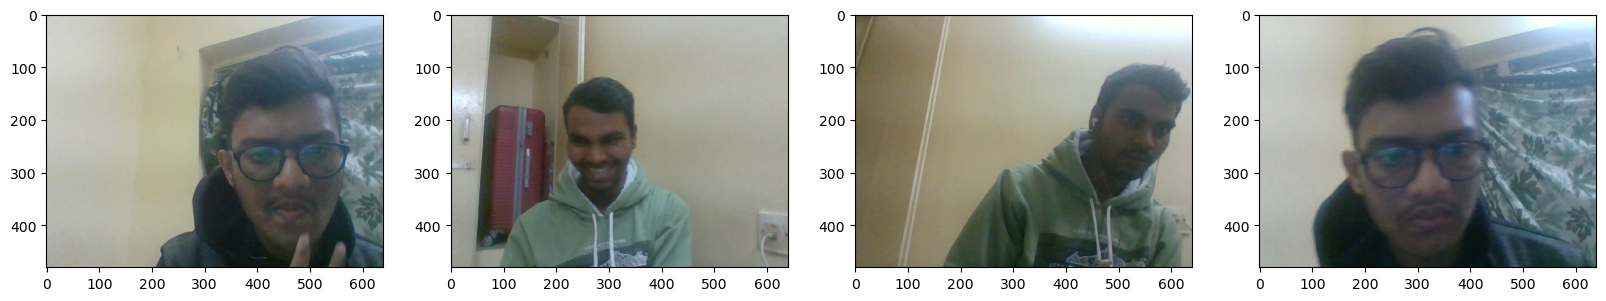

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Partition Unagumented Data 

In [23]:
# manually split the whole data into train, test and validation set
#74* 0.7 == 51.8
#52--->train
# 11--->test
#11---->val

In [26]:
# Move the matching images which are passed in train, test and val by cutting and pasting
#this code will do the job
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

# Apply augmentation in all folder images

Setting up the albumentation Transform pipeline

In [29]:
# importing albumentation
import albumentations as alb

In [30]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                       alb.HorizontalFlip(p=0.5),
                       alb.RandomBrightnessContrast(p=0.2),
                       alb.RandomGamma(0.2),
                       alb.RGBShift(p=0.2),
                       alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

Load up an image and test the pipline

In [32]:
img = cv2.imread(os.path.join('data', 'train', 'images', '1ad03932-8d5a-11ed-ada0-e4e7496531cc.jpg'))

In [33]:
img

array([[[ 77, 101, 101],
        [ 80, 104, 104],
        [ 85, 106, 108],
        ...,
        [236, 221, 218],
        [240, 221, 218],
        [240, 221, 218]],

       [[ 77, 100, 102],
        [ 79, 102, 104],
        [ 83, 104, 106],
        ...,
        [237, 223, 217],
        [241, 222, 219],
        [241, 222, 217]],

       [[ 76,  98, 103],
        [ 78, 100, 105],
        [ 79, 101, 106],
        ...,
        [238, 225, 217],
        [242, 223, 218],
        [241, 223, 216]],

       ...,

       [[ 82, 105, 107],
        [ 82, 105, 107],
        [ 83, 106, 108],
        ...,
        [135, 146, 144],
        [138, 146, 145],
        [138, 146, 145]],

       [[ 79, 104, 106],
        [ 80, 105, 107],
        [ 80, 105, 107],
        ...,
        [135, 146, 144],
        [138, 146, 145],
        [138, 146, 145]],

       [[ 79, 104, 106],
        [ 79, 104, 106],
        [ 79, 104, 106],
        ...,
        [135, 146, 144],
        [137, 145, 144],
        [138, 146, 145]]

In [34]:
with open(os.path.join('data', 'train', 'labels', '1ad03932-8d5a-11ed-ada0-e4e7496531cc.json'), 'r') as f:
    label = json.load(f)

In [39]:
label['shapes'][0]['points']

[[311.55844155844153, 184.15584415584416],
 [471.29870129870125, 416.62337662337666]]

Extract coordinate and Rescale to match Image Resolution 

In [40]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [41]:
coords

[311.55844155844153,
 184.15584415584416,
 471.29870129870125,
 416.62337662337666]

In [42]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [43]:
coords

[0.4868100649350649, 0.3836580086580087, 0.7364042207792207, 0.867965367965368]

Apply augmentation and view Results

In [44]:
augmented = augmentor(image=img, bboxes = [coords], class_labels=['face'])

In [45]:
augmented

{'image': array([[[106, 112,  87],
         [105, 111,  86],
         [104, 110,  85],
         ...,
         [ 93, 108, 117],
         [ 94, 110, 117],
         [ 94, 110, 117]],
 
        [[108, 114,  89],
         [108, 114,  89],
         [108, 112,  87],
         ...,
         [ 94, 109, 118],
         [ 95, 111, 118],
         [ 95, 111, 118]],
 
        [[112, 116,  91],
         [112, 116,  91],
         [111, 115,  90],
         ...,
         [ 96, 109, 117],
         [ 95, 111, 118],
         [ 95, 111, 118]],
 
        ...,
 
        [[207, 199, 199],
         [207, 199, 199],
         [207, 200, 197],
         ...,
         [ 78,  99, 107],
         [ 81, 102, 110],
         [ 81, 102, 110]],
 
        [[208, 201, 198],
         [207, 200, 197],
         [208, 202, 197],
         ...,
         [ 80,  99, 106],
         [ 79, 101, 107],
         [ 80, 102, 108]],
 
        [[208, 201, 198],
         [207, 200, 197],
         [207, 201, 196],
         ...,
         [ 81, 100,

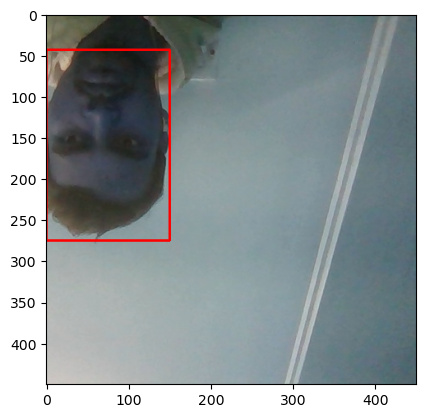

In [49]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
              (255,0,0), 2)

plt.imshow(augmented['image'])

In [31]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
    
        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
    
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
        
            coords = list(np.divide(coords, [640, 480, 640, 480]))
        
        try:
            for x in range(90):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                    
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)    

x_max is less than or equal to x_min for bbox [0.9941152597402597, 0.8544372294372294, 0.8561282467532466, 0.27813852813852813, 'face'].
x_max is less than or equal to x_min for bbox [0.5273944805194806, 0.775974025974026, 0.2493912337662338, 0.24837662337662342, 'face'].


C:\Users\HP\anaconda\lib\site-packages\albumentations\augmentations\functional.py:781: RuntimeWarning: divide by zero encountered in power
  table = (np.arange(0, 256.0 / 255, 1.0 / 255) ** gamma) * 255


x_max is less than or equal to x_min for bbox [0.9007711038961039, 0.775974025974026, 0.5071022727272727, 0.09415584415584419, 'face'].
x_max is less than or equal to x_min for bbox [0.7201704545454545, 0.6352813852813852, 0.45028409090909094, 0.14285714285714288, 'face'].
x_max is less than or equal to x_min for bbox [0.7769886363636364, 0.8436147186147186, 0.4827516233766233, 0.3457792207792208, 'face'].
x_max is less than or equal to x_min for bbox [0.6856737012987012, 0.6028138528138529, 0.4543425324675324, 0.1726190476190477, 'face'].
x_max is less than or equal to x_min for bbox [0.5700081168831168, 0.573051948051948, 0.3386769480519481, 0.11850649350649357, 'face'].
x_max is less than or equal to x_min for bbox [0.32853084415584416, 0.7895021645021646, 0.014001623376623386, 0.25649350649350655, 'face'].
x_max is less than or equal to x_min for bbox [0.6633522727272727, 0.849025974025974, 0.265625, 0.040043290043290075, 'face'].
y_max is less than or equal to y_min for bbox [0.26

# Loading Augmented Data into Tensorflow Datasheet

In [32]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [33]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [34]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [35]:
train_images.as_numpy_iterator().next()

array([[[0.14656863, 0.20539215, 0.12487745],
        [0.14656863, 0.20539215, 0.13088235],
        [0.1463848 , 0.20275736, 0.1331495 ],
        ...,
        [0.33658087, 0.321875  , 0.20177697],
        [0.35      , 0.32696077, 0.19718137],
        [0.34675246, 0.32156864, 0.190625  ]],

       [[0.14852941, 0.20735294, 0.125     ],
        [0.1533701 , 0.21219362, 0.13670343],
        [0.15294118, 0.21323529, 0.13725491],
        ...,
        [0.34515932, 0.32555148, 0.20790441],
        [0.36182597, 0.32849264, 0.20870098],
        [0.36145833, 0.327451  , 0.20594363]],

       [[0.14901961, 0.20784314, 0.13039216],
        [0.15588236, 0.21470588, 0.13235295],
        [0.14215687, 0.2127451 , 0.1264706 ],
        ...,
        [0.3485294 , 0.3367647 , 0.21519607],
        [0.3396446 , 0.32101715, 0.2028799 ],
        [0.33872548, 0.3142157 , 0.19607843]],

       ...,

       [[1.        , 1.        , 0.9843137 ],
        [1.        , 1.        , 0.9843137 ],
        [1.        , 1

# Prepare Labels

In [36]:
# build loading function
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

load label to tensorflow Datasheet

In [37]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2622, 0.2435, 0.675 , 0.8237], dtype=float16))

# Combine Label and image samples

In [41]:
#check partition length
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 810, 810, 720, 720)

Creating the final Datasets

In [42]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [43]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [44]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [45]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3213   , 0.09863  , 0.6763   , 0.615    ],
        [0.1997   , 0.2301   , 0.5923   , 0.66     ],
        [0.       , 0.0849   , 0.2546   , 0.697    ],
        [0.51     , 0.07996  , 0.92     , 0.6543   ],
        [0.7007   , 0.2288   , 1.       , 0.5864   ],
        [0.5156   , 0.3296   , 0.842    , 0.765    ],
        [0.0019045, 0.04044  , 0.4607   , 0.557    ],
        [0.3657   , 0.3833   , 0.6772   , 0.796    ]], dtype=float16))

# View Images and Annotation

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


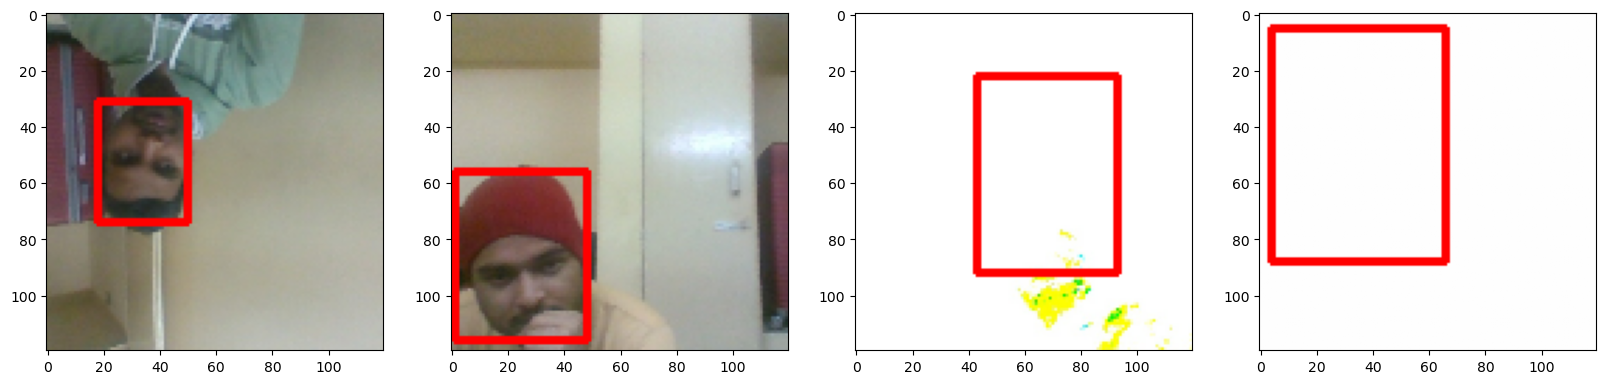

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build deep learning model using Function API

In [55]:
# import layers and base network
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Flatten, Add, GlobalMaxPool2D
from keras.applications.vgg16 import VGG16

In [56]:
#Download VGG16 Base model
vgg16 = VGG16(include_top=False)

In [57]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [60]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg16 = VGG16(include_top=False)(input_layer)
    
    f1 = GlobalMaxPool2D()(vgg16)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    f2 = GlobalMaxPool2D()(vgg16)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs = [class2, regress2])
    return facetracker

In [61]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.1929, 0.0647, 0.7847, 0.9043],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1113, 0.1279, 0.495 , 0.6475],
        [0.    , 0.    , 0.    , 0.    ],
        [0.3843, 0.3052, 0.7104, 0.7407],
        [0.559 , 0.4229, 1.    , 0.9395],
        [0.    , 0.    , 0.    , 0.    ],
        [0.846 , 0.579 , 1.    , 1.    ]], dtype=float16))

# Test Our Neural Network

In [62]:
facetracker = build_model()

In [63]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_3[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [64]:
X, y = train.as_numpy_iterator().next()

In [65]:
X

array([[[[0.6425858 , 0.65042895, 0.63082105],
         [0.64705884, 0.654902  , 0.63529414],
         [0.6544118 , 0.65833336, 0.6362745 ],
         ...,
         [0.68694854, 0.6908701 , 0.67126226],
         [0.6887255 , 0.69264704, 0.6696078 ],
         [0.69166666, 0.69558823, 0.6720588 ]],

        [[0.6473652 , 0.65520835, 0.6356005 ],
         [0.64362746, 0.6509804 , 0.6313726 ],
         [0.654902  , 0.65882355, 0.6392157 ],
         ...,
         [0.67941177, 0.68333334, 0.6637255 ],
         [0.69074756, 0.6946691 , 0.6716299 ],
         [0.6856005 , 0.69442403, 0.6684436 ]],

        [[0.64705884, 0.6509804 , 0.6313726 ],
         [0.65006125, 0.6539828 , 0.634375  ],
         [0.64705884, 0.6509804 , 0.627451  ],
         ...,
         [0.6945466 , 0.69846815, 0.6788603 ],
         [0.69754905, 0.7014706 , 0.6784314 ],
         [0.6841299 , 0.6929534 , 0.66697305]],

        ...,

        [[0.29626226, 0.38645834, 0.36292893],
         [0.2827206 , 0.37947303, 0.35735294]

In [66]:
y

(array([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.08044, 0.1879 , 0.6924 ],
        [0.256  , 0.2546 , 0.669  , 0.835  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.0662 , 0.06195, 0.704  , 0.916  ],
        [0.1976 , 0.2272 , 0.778  , 1.     ],
        [0.2974 , 0.0775 , 0.935  , 0.9316 ],
        [0.     , 0.321  , 0.2625 , 0.7163 ]], dtype=float16))

In [67]:
X.shape

(8, 120, 120, 3)

In [68]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [69]:
classes, coords

(array([[0.52997863],
        [0.53429615],
        [0.4608081 ],
        [0.46112174],
        [0.6251675 ],
        [0.49512416],
        [0.48295227],
        [0.49085706]], dtype=float32),
 array([[0.5452619 , 0.5394481 , 0.47122487, 0.38252425],
        [0.5459707 , 0.569083  , 0.39146203, 0.38751057],
        [0.58564675, 0.4614998 , 0.4216549 , 0.38773787],
        [0.5856481 , 0.46164668, 0.42150864, 0.38790807],
        [0.47697943, 0.408191  , 0.36065456, 0.40946764],
        [0.5314573 , 0.5191979 , 0.46270013, 0.4228124 ],
        [0.66986865, 0.5542017 , 0.3935169 , 0.41908723],
        [0.4688765 , 0.4498249 , 0.41727468, 0.4269736 ]], dtype=float32))

# Define loss and optimizers

In [70]:
len(train)

450

In [71]:
batches_per_epochs = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epochs

In [72]:
lr_decay

0.0007407407407407406

In [73]:
opt = tf.keras.optimizers.Adam(learning_rate =0.0001 , decay = lr_decay )

# Creating Localization and classification Loss

In [86]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [87]:
class_loss = tf.keras.losses.BinaryCrossentropy()
reg_loss = localization_loss

# Test out loss metrics

In [88]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.0766735>

# Train Our neural Network

In [89]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [90]:
model = FaceTracker(facetracker)

In [91]:
model.compile(opt, class_loss, reg_loss)

# train

In [92]:
logdir='logs'

In [93]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=2, validation_data=val, callbacks=[tensorboard_callback])

# Plotting the performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Make Prediction

In [ ]:
test_data = test.as_numpy_iteratorpy_iterator_numpy_iterator_numpy_iterator_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetrackeracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

# Real time detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()

In [ ]:
print(5)